In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task with a user specified data set and a user specified regression model.

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on a user data set, which can be found in the subfolder of this notebook, `userData`.
The network can be found in the subfolder `userModel`.

## Step 1: Setup {#sec-setup-33}

* Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, etc. 
* The parameter `MAX_TIME` specifies the maximum run time in seconds.
* The parameter `INIT_SIZE` specifies the initial design size.
* The parameter `WORKERS` specifies the number of workers. 
* The prefix `PREFIX` is used for the experiment name and the name of the log file.
* The parameter `DEVICE` specifies the device to use for training.


In [1]:
from spotPython.utils.device import getDevice
from math import inf

MAX_TIME = 10
FUN_EVALS = inf
FUN_REPEATS = 2
OCBA_DELTA = 1
REPEATS = 2
INIT_SIZE = 10
WORKERS = 0
PREFIX="032"
DEVICE = getDevice()
DEVICES = 1
TEST_SIZE = 0.3

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `WORKERS` is set to 0 for demonstration purposes. For real experiments, this should be increased. See the warnings that are printed when the number of workers is set to 0.

:::

::: {.callout-note}
### Note: Device selection

* Although there are no .cuda() or .to(device) calls required, because Lightning does these for you, see 
[LIGHTNINGMODULE](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), we would like to know which device is used. Threrefore, we imitate the LightningModule behaviour which selects the highest device. 
* The method `spotPython.utils.device.getDevice()` returns the device that is used by Lightning.
:::


## Step 2: Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process.


In [2]:
from spotPython.utils.init import fun_control_init
import numpy as np
fun_control = fun_control_init(
    _L_in=6,
    _L_out=1,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    device=DEVICE,
    enable_progress_bar=False,
    fun_evals=FUN_EVALS,
    fun_repeats=FUN_REPEATS,
    log_level=10,
    max_time=MAX_TIME,
    num_workers=WORKERS,
    ocba_delta = OCBA_DELTA,
    show_progress=True,
    test_size=TEST_SIZE,
    tolerance_x=np.sqrt(np.spacing(1)),
    verbosity=1,
    )

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_02_20_03_20_57
Created spot_tensorboard_path: runs/spot_logs/032_bartz09_2024-02-20_03-20-57 for SummaryWriter()


## Step 3: Loading the User Specified Data Set


In [3]:
# from spotPython.hyperparameters.values import set_control_key_value
# from spotPython.data.pkldataset import PKLDataset
# import torch
# dataset = PKLDataset(directory="./userData/",
#                      filename="data_sensitive.pkl",
#                      target_column='N',
#                      feature_type=torch.float32,
#                      target_type=torch.float32,
#                      rmNA=True)
# set_control_key_value(control_dict=fun_control,
#                         key="data_set",
#                         value=dataset,
#                         replace=True)
# print(len(dataset))

::: {.callout-note}
### Note: Data Set and Data Loader

* As shown below, a DataLoader from `torch.utils.data` can be used to check the data.


In [4]:
# if the package pyhcf is installed then print "pyhcf is installed" else print "pyhcf is not installed"
try:
    import pyhcf
    print("pyhcf is installed")
    from pyhcf.data.loadHcfData import load_hcf_data
    dataset = load_hcf_data(A=True, H=True,
                        param_list=['H', 'D', 'L', 'K', 'E', 'I', 'N'],
                        target='N', rmNA=True, rmMF=True, scale_data=True, return_X_y=False)
except ImportError:
    print("pyhcf is not installed")
    from spotPython.data.pkldataset import PKLDataset
    import torch
    dataset = PKLDataset(directory="./userData/",
                        filename="data_sensitive.pkl",
                        target_column='N',
                        feature_type=torch.float32,
                        target_type=torch.float32,
                        rmNA=True)

pyhcf is installed


Loading data for ['H', 'D', 'L', 'K', 'E', 'I', 'N']...


In [5]:
from spotPython.hyperparameters.values import set_control_key_value
set_control_key_value(control_dict=fun_control,
                        key="data_set",
                        value=dataset,
                        replace=True)
print(len(dataset))

41837


In [6]:
# Set batch size for DataLoader
batch_size = 5
# Create DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
 
# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Targets Shape: {targets.shape}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 5
Inputs Shape: torch.Size([5, 6])
Targets Shape: torch.Size([5])
---------------
Inputs: tensor([[0.0033, 0.4000, 0.0000, 0.7500, 1.0000, 0.1667],
        [0.0246, 0.4000, 0.0435, 0.7500, 1.0000, 0.1667],
        [0.0275, 0.4000, 0.0435, 0.7500, 1.0000, 0.1667],
        [0.0285, 0.4000, 0.0435, 0.7500, 1.0000, 0.1667],
        [0.0285, 0.4000, 0.0435, 0.7500, 1.0000, 0.1667]])
Targets: tensor([4.5764, 4.9073, 6.2846, 5.5094, 5.6079])


:::
## Step 4: Preprocessing {#sec-preprocessing-33}

Preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.

## Step 5: Select the Core Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-33}

`spotPython` includes the `NetLightRegression` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightregression.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

* Here we simply add the NN Model to the fun_control dictionary by calling the function `add_core_model_to_fun_control`:

We can use aconfiguration from the `spotPython` package:


In [7]:
#| eval: false
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=NetLightRegression,
                              hyper_dict=LightHyperDict)

* Alternatively, we can use a userr configuration from the subdirectory `userModel`:


In [8]:
#| eval: true
from spotPython.hyperparameters.values import add_core_model_to_fun_control
import sys
sys.path.insert(0, './userModel')
import netlightregression
import light_hyper_dict
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=netlightregression.NetLightRegression,
                              hyper_dict=light_hyper_dict.LightHyperDict)

The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json).



## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-33}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. 

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `set_control_hyperparameter_value(fun_control, "epochs", [7, 9])` and
  * `set_control_hyperparameter_value(fun_control, "patience", [2, 7])`

:::

::: {.callout-note}
#### Note: Pre-experimental Results

* The following hyperparameters {@tbl-pre-experimental-results-33} have generated acceptable results (obtained in in pre-experimental runs):

| Hyperparameter | Value |
|----------------|-------|
| `act_fn` | `LeakyReLU` |
| `batch_size` | `16` |
| `dropout_prob` | `0.01` |
| `epochs` | `512` |
| `initialization` | `Default` |
| `l1` | `128` |
| `lr_mult` | `0.5` |
| `optimizer` | `Adagrad` |
| `patience` | `16` |

: Table 1: Pre-experimental results for the user specified data set. The test set size is 715, the train set size is 1167, and the batch size is 16. {#tbl-pre-experimental-results-33}

Therefore, we will use these values as the starting poing for the hyperparameter tuning.

:::


In [9]:
from spotPython.hyperparameters.values import set_control_hyperparameter_value

set_control_hyperparameter_value(fun_control, "l1", [5, 9])
set_control_hyperparameter_value(fun_control, "epochs", [5, 10])
set_control_hyperparameter_value(fun_control, "batch_size", [3, 6])
set_control_hyperparameter_value(fun_control, "optimizer", [
                "Adadelta",
                "Adamax",
                "Adagrad"
            ])
set_control_hyperparameter_value(fun_control, "dropout_prob", [0.005, 0.25])
set_control_hyperparameter_value(fun_control, "lr_mult", [0.25, 5.0])
set_control_hyperparameter_value(fun_control, "patience", [3,5])
set_control_hyperparameter_value(fun_control, "act_fn",[
                "ReLU",
                "LeakyReLU",
            ] )
set_control_hyperparameter_value(fun_control, "initialization",["Default"] )

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/utils/eda.py) generates a design table as follows:


In [10]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |   5     |    9    | transform_power_2_int |
| epochs         | int    | 4         |   5     |   10    | transform_power_2_int |
| batch_size     | int    | 4         |   3     |    6    | transform_power_2_int |
| act_fn         | factor | ReLU      |   0     |    1    | None                  |
| optimizer      | factor | SGD       |   0     |    2    | None                  |
| dropout_prob   | float  | 0.01      |   0.005 |    0.25 | None                  |
| lr_mult        | float  | 1.0       |   0.25  |    5    | None                  |
| patience       | int    | 2         |   3     |    5    | transform_power_2_int |
| initialization | factor | Default   |   0     |    0    | None                  |


This allows to check if all information is available and if the information is correct.

::: {.callout-note}
### Note: Hyperparameters of the Tuned Model and the `fun_control` Dictionary
The updated `fun_control` dictionary can be shown with the command `fun_control["core_model_hyper_dict"]`.
:::


## Step 7: Data Splitting, the Objective (Loss) Function and the Metric

### Evaluation  {#sec-selection-of-target-function-33}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set
2. the loss function (and a metric).

::: {.callout-caution}
### Caution: Data Splitting in Lightning

The data splitting is handled by `Lightning`.

:::

### Loss Function {#sec-loss-function-33}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py)
We will use MSE.

### Metric {#sec-metric-33}

* Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py).

::: {.callout-caution}
### Caution: Loss Function and Metric in Lightning

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

:::


## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-33}


In [11]:
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init(init_size=INIT_SIZE,
                                     repeats=REPEATS,)

surrogate_control = surrogate_control_init(noise=True,
                                            n_theta=2,
                                            min_Lambda=1e-6,
                                            max_Lambda=10,
                                            log_level=10,)

::: {.callout-note}
### Note: Modifying Values in the Control Dictionaries 

* The values in the control dictionaries can be modified with the function `set_control_key_value` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py), for example:





```{raw}
set_control_key_value(control_dict=surrogate_control,
                        key="noise",
                        value=True,
                        replace=True)                       
set_control_key_value(control_dict=surrogate_control,
                        key="n_theta",
                        value=2,
                        replace=True)      

```




:::

### The Objective Function `fun` {#sec-the-objective-function-33}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.


In [12]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=10).fun

### Showing the fun_control Dictionary {#sec-show-fun-control-33}


In [13]:
import pprint
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '032',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 6,
 '_L_out': 1,
 'accelerator': 'auto',
 'converters': None,
 'core_model': <class 'netlightregression.NetLightRegression'>,
 'core_model_hyper_dict': {'act_fn': {'class_name': 'spotPython.torch.activation',
                                      'core_model_parameter_type': 'instance()',
                                      'default': 'ReLU',
                                      'levels': ['ReLU', 'LeakyReLU'],
                                      'lower': 0,
                                      'transform': 'None',
                                      'type': 'factor',
                                      'upper': 1},
                           'batch_size': {'default': 4,
                                          'lower': 3,
                                          'transform': 'transform_power_2_int',
                     

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-33}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py).


In [14]:
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                       fun_control=fun_control,
                       design_control=design_control,
                       surrogate_control=surrogate_control)
spot_tuner.run()

Seed set to 123


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 64,
 'dropout_prob': 0.20560368458693354,
 'epochs': 128,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 4.561411125937148,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 64
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.1 K  | [64, 6]  | [64, 1]  
-------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


LightDataModule: train_dataloader(). Training set size: 20501
LightDataModule: train_dataloader(). batch_size: 64
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     20.20969009399414     │
│         val_loss          │     20.20969009399414     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.1 K  | [64, 6]  | [64, 1]  
-------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


train_model result: {'val_loss': 20.20969009399414, 'hp_metric': 20.20969009399414}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 64,
 'dropout_prob': 0.20560368458693354,
 'epochs': 128,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 4.561411125937148,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 64
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDa

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    20.051761627197266     │
│         val_loss          │    20.051761627197266     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [64, 6]  | [64, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 20.051761627197266, 'hp_metric': 20.051761627197266}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 64,
 'dropout_prob': 0.02426280739731016,
 'epochs': 256,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 1.322803150188513,
 'optimizer': 'Adagrad',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 64
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Li

`Trainer.fit` stopped: `max_epochs=256` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     15.70073127746582     │
│         val_loss          │     15.70073127746582     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [64, 6]  | [64, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 15.70073127746582, 'hp_metric': 15.70073127746582}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 64,
 'dropout_prob': 0.02426280739731016,
 'epochs': 256,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 1.322803150188513,
 'optimizer': 'Adagrad',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 64
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Ligh

`Trainer.fit` stopped: `max_epochs=256` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 64
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    15.502586364746094     │
│         val_loss          │    15.502586364746094     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.2 K  | [8, 6]   | [8, 1]   
-------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 15.502586364746094, 'hp_metric': 15.502586364746094}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 8,
 'dropout_prob': 0.07443535216560176,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 32,
 'lr_mult': 2.863550239963548,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 8
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataMo

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 8
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     15.79671859741211     │
│         val_loss          │     15.79671859741211     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.2 K  | [8, 6]   | [8, 1]   
-------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 15.79671859741211, 'hp_metric': 15.79671859741211}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 8,
 'dropout_prob': 0.07443535216560176,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 32,
 'lr_mult': 2.863550239963548,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 8
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModu

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 8
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    16.472652435302734     │
│         val_loss          │    16.472652435302734     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.1 K  | [32, 6]  | [32, 1]  
-------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


train_model result: {'val_loss': 16.472652435302734, 'hp_metric': 16.472652435302734}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.18567441685948113,
 'epochs': 64,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 4.089366778039889,
 'optimizer': 'Adagrad',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightData

`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    18.945697784423828     │
│         val_loss          │    18.945697784423828     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.1 K  | [32, 6]  | [32, 1]  
-------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


train_model result: {'val_loss': 18.945697784423828, 'hp_metric': 18.945697784423828}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.18567441685948113,
 'epochs': 64,
 'initialization': 'Default',
 'l1': 64,
 'lr_mult': 4.089366778039889,
 'optimizer': 'Adagrad',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightData

`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    18.523624420166016     │
│         val_loss          │    18.523624420166016     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [32, 6]  | [32, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 18.523624420166016, 'hp_metric': 18.523624420166016}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.13080206803532848,
 'epochs': 256,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 2.0077669995722074,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDat

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    15.432626724243164     │
│         val_loss          │    15.432626724243164     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [32, 6]  | [32, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 15.432626724243164, 'hp_metric': 15.432626724243164}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 32,
 'dropout_prob': 0.13080206803532848,
 'epochs': 256,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 2.0077669995722074,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDat

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    15.104686737060547     │
│         val_loss          │    15.104686737060547     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [32, 6]  | [32, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 15.104686737060547, 'hp_metric': 15.104686737060547}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 32,
 'dropout_prob': 0.11983781472185623,
 'epochs': 1024,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 0.7181246235247182,
 'optimizer': 'Adadelta',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    16.840728759765625     │
│         val_loss          │    16.840728759765625     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [32, 6]  | [32, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 16.840728759765625, 'hp_metric': 16.840728759765625}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 32,
 'dropout_prob': 0.11983781472185623,
 'epochs': 1024,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 0.7181246235247182,
 'optimizer': 'Adadelta',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 32
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 32
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     17.4989013671875      │
│         val_loss          │     17.4989013671875      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 17.4989013671875, 'hp_metric': 17.4989013671875}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.09366384017851244,
 'epochs': 64,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 3.301460285082441,
 'optimizer': 'Adadelta',
 'patience': 32}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightD

`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     22.83207893371582     │
│         val_loss          │     22.83207893371582     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 59.5 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
59.5 K    Trainable params
0         Non-trainable params
59.5 K    Total params
0.238     Total estimated model params size (MB)


train_model result: {'val_loss': 22.83207893371582, 'hp_metric': 22.83207893371582}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.09366384017851244,
 'epochs': 64,
 'initialization': 'Default',
 'l1': 256,
 'lr_mult': 3.301460285082441,
 'optimizer': 'Adadelta',
 'patience': 32}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Ligh

`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    22.913419723510742     │
│         val_loss          │    22.913419723510742     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 22.913419723510742, 'hp_metric': 22.913419723510742}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.03540914713540524,
 'epochs': 32,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 3.7811076839948083,
 'optimizer': 'Adamax',
 'patience': 32}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Lig

`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    17.299013137817383     │
│         val_loss          │    17.299013137817383     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 17.299013137817383, 'hp_metric': 17.299013137817383}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.03540914713540524,
 'epochs': 32,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 3.7811076839948083,
 'optimizer': 'Adamax',
 'patience': 32}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Lig

`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     17.1027774810791      │
│         val_loss          │     17.1027774810791      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 17.1027774810791, 'hp_metric': 17.1027774810791}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 16,
 'dropout_prob': 0.23933451103594558,
 'epochs': 128,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 0.9693203335370014,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataMod

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    17.801963806152344     │
│         val_loss          │    17.801963806152344     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.4 K | [16, 6]  | [16, 1]  
-------------------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


train_model result: {'val_loss': 17.801963806152344, 'hp_metric': 17.801963806152344}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 16,
 'dropout_prob': 0.23933451103594558,
 'epochs': 128,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 0.9693203335370014,
 'optimizer': 'Adamax',
 'patience': 8}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDat

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    15.633362770080566     │
│         val_loss          │    15.633362770080566     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


train_model result: {'val_loss': 15.633362770080566, 'hp_metric': 15.633362770080566}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 16,
 'dropout_prob': 0.15827496187066842,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 512,
 'lr_mult': 2.4208305977937328,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDa

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    14.050446510314941     │
│         val_loss          │    14.050446510314941     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


train_model result: {'val_loss': 14.050446510314941, 'hp_metric': 14.050446510314941}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 16,
 'dropout_prob': 0.15827496187066842,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 512,
 'lr_mult': 2.4208305977937328,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDa

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    13.820969581604004     │
│         val_loss          │    13.820969581604004     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 13.820969581604004, 'hp_metric': 13.820969581604004}


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)



In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.1647723988730034,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 512,
 'lr_mult': 1.840511917259318,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    15.127991676330566     │
│         val_loss          │    15.127991676330566     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


train_model result: {'val_loss': 15.127991676330566, 'hp_metric': 15.127991676330566}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 16,
 'dropout_prob': 0.1647723988730034,
 'epochs': 512,
 'initialization': 'Default',
 'l1': 512,
 'lr_mult': 1.840511917259318,
 'optimizer': 'Adamax',
 'patience': 16}
LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
train_model(): Test set size: 12552
train_model(): Train set size: 20501
train_model(): Batch size: 16
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
Ligh

LightDataModule: setup(). stage: TrainerFn.VALIDATING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    14.914267539978027     │
│         val_loss          │    14.914267539978027     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 14.914267539978027, 'hp_metric': 14.914267539978027}


spotPython tuning: 13.820969581604004 [##########] 100.00% Done...



## Step 9: Tensorboard {#sec-tensorboard-33}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.





```{raw}
tensorboard --logdir="runs/"
```





Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.



## Step 10: Results {#sec-results-33}

After the hyperparameter tuning run is finished, the results can be analyzed.


In [15]:
if spot_tuner.noise:
    print(spot_tuner.min_mean_X)
    print(spot_tuner.min_mean_y)
else:
    print(spot_tuner.min_X)
    print(spot_tuner.min_y)

[9.         9.         4.         0.         1.         0.15827496
 2.4208306  4.        ]
13.820969581604004


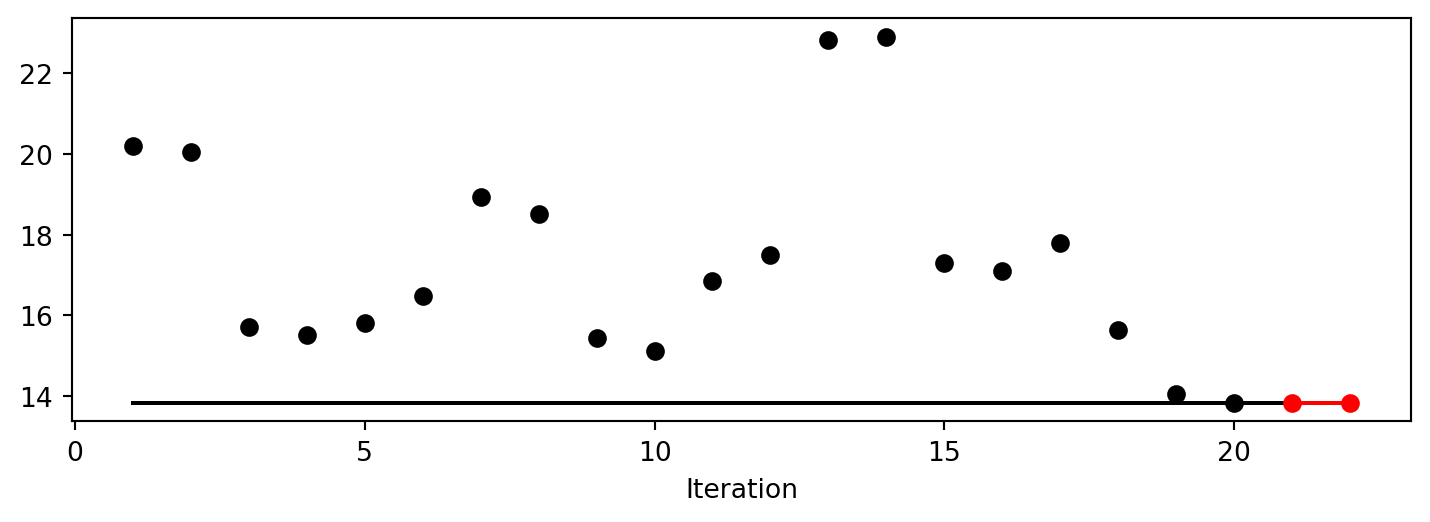

In [16]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False,
    filename="./figures/" + PREFIX +"_progress.png")

In [17]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned               | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     5.0 |     9.0 | 9.0                 | transform_power_2_int |         0.01 |         |
| epochs         | int    | 4         |     5.0 |    10.0 | 9.0                 | transform_power_2_int |         0.00 |         |
| batch_size     | int    | 4         |     3.0 |     6.0 | 4.0                 | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     1.0 | ReLU                | None                  |         0.00 |         |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adamax              | None                  |       100.00 | ***     |
| dropout_prob   | float  | 0.01      |   0.005 |    0.25 | 0.15827496187066842 | N

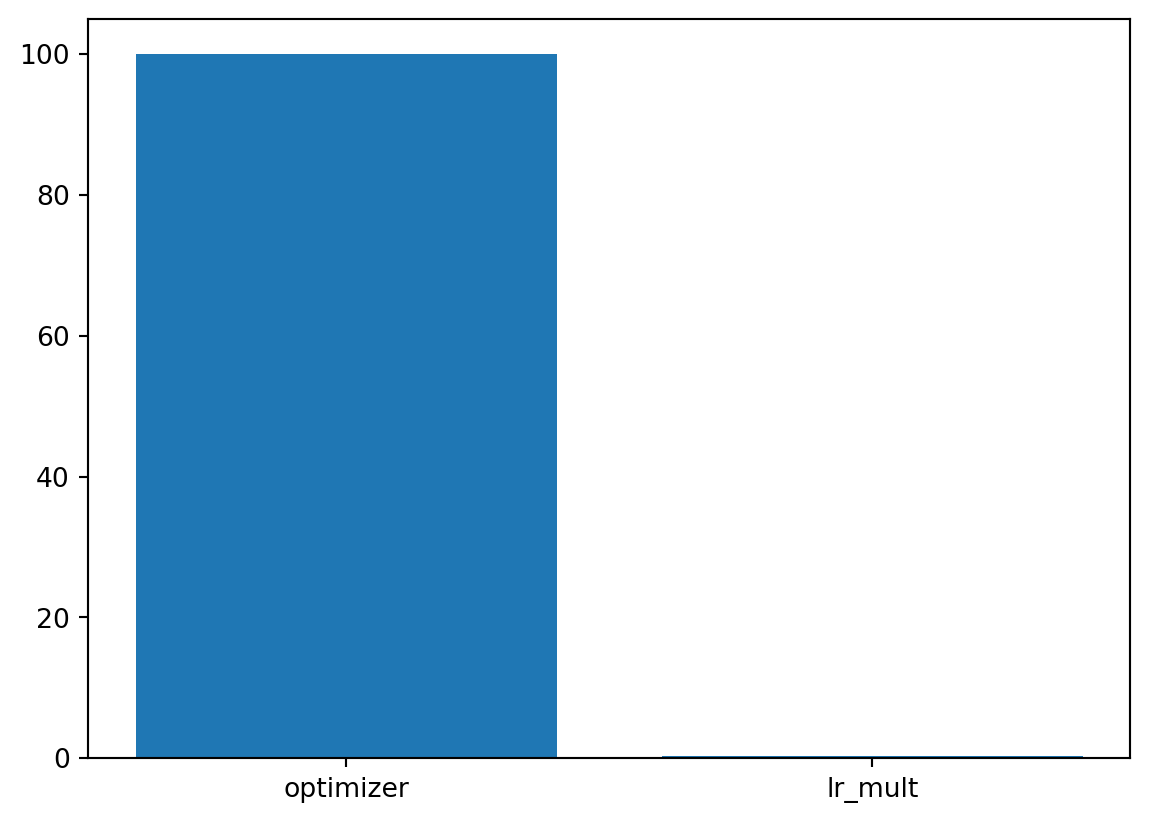

In [18]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025,
    filename="./figures/" + PREFIX + "_importance.png")

### Get the Tuned Architecture {#sec-get-spot-results-33}


In [19]:
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
print(config)

{'l1': 512, 'epochs': 512, 'batch_size': 16, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.15827496187066842, 'lr_mult': 2.4208305977937328, 'patience': 16, 'initialization': 'Default'}


* Test on the full data set


In [20]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


LightDataModule: setup(). stage: None
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: setup(). stage: test
LightDataModule: setup(). stage: predict
LightDataModule: setup(). stage: TrainerFn.FITTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: fit
LightDataModule: val_dataloader(). Training set size: 8785
LightDataModule: val_dataloader(). batch_size: 16
LightDataModule: val_dataloader(). num_workers: 0
LightDataModule: train_dataloader(). Training set size: 20501
LightDataModule: train_dataloader(). batch_size: 16
LightDataModule: train_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/512_512_16_ReLU_Adamax_0.1583_2.4208_16_Default_TEST/last.ckpt


Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/512_512_16_ReLU_Adamax_0.1583_2.4208_16_Default_TEST/last.ckpt


LightDataModule: setup(). stage: TrainerFn.TESTING
LightDataModule setup(): full_train_size: 0.7
LightDataModule setup(): val_size: 0.21
LightDataModule setup(): train_size: 0.49
LightDataModule setup(): test_size: 0.3
LightDataModule: setup(). stage: test
LightDataModule: test_dataloader(). Test set size: 12552
LightDataModule: test_dataloader(). batch_size: 16
LightDataModule: test_dataloader(). num_workers: 0


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    16.362627029418945     │
│         val_loss          │    16.362627029418945     │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 16.362627029418945, 'hp_metric': 16.362627029418945}


(16.362627029418945, 16.362627029418945)

In [21]:
from spotPython.light.loadmodel import load_light_from_checkpoint

model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'l1': 512, 'epochs': 512, 'batch_size': 16, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.15827496187066842, 'lr_mult': 2.4208305977937328, 'patience': 16, 'initialization': 'Default'}
Loading model with 512_512_16_ReLU_Adamax_0.1583_2.4208_16_Default_TEST from runs/saved_models/512_512_16_ReLU_Adamax_0.1583_2.4208_16_Default_TEST/last.ckpt


Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15827496187066842, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15827496187066842, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15827496187066842, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.15827496187066842, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)


optimizer:  100.0
lr_mult:  0.2359217453545927
impo: [['l1', 0.008491788212338527], ['epochs', 0.001], ['batch_size', 0.001], ['act_fn', 0.001], ['optimizer', 100.0], ['dropout_prob', 0.001], ['lr_mult', 0.2359217453545927], ['patience', 0.001]]
impo after select: [['l1', 0.008491788212338527], ['epochs', 0.001], ['batch_size', 0.001], ['act_fn', 0.001], ['optimizer', 100.0], ['dropout_prob', 0.001], ['lr_mult', 0.2359217453545927], ['patience', 0.001]]


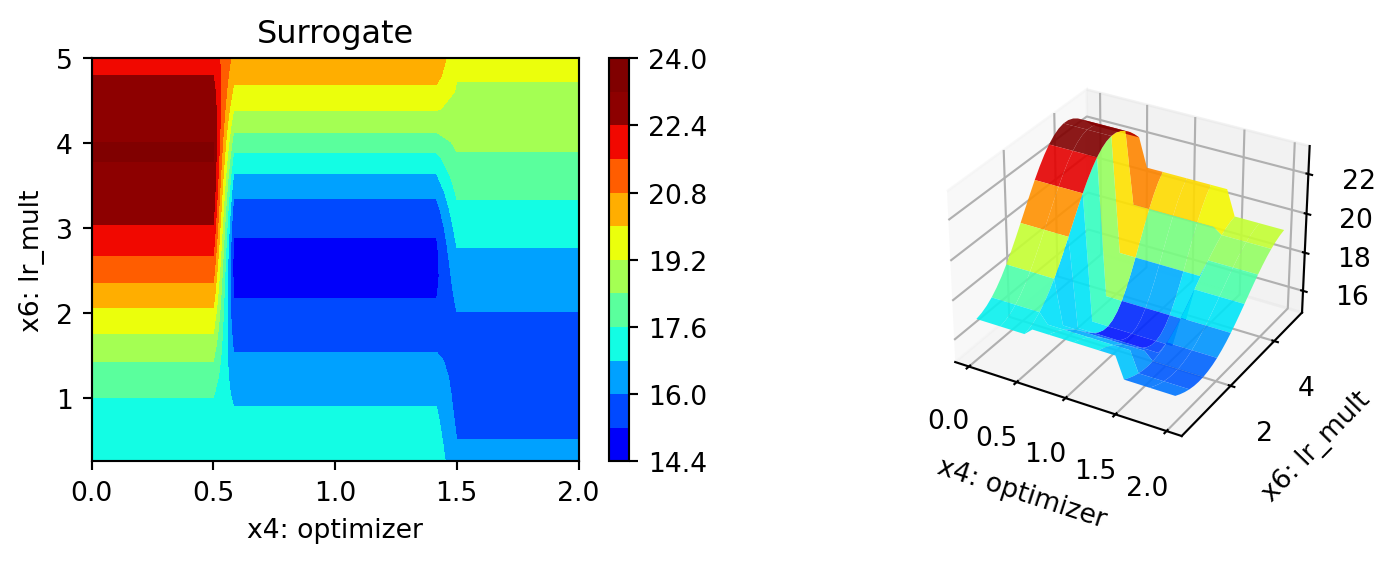

In [22]:
#| fig-cap: Contour plots.
filename = "./figures/" + PREFIX
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

### Parallel Coordinates Plot


In [23]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/cvmodel.py).


In [24]:
from spotPython.light.cvmodel import cv_model
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.6,
                        replace=True)
cv_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


k: 0
Train Dataset Size: 20918
Val Dataset Size: 20919


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    14.243213653564453     │
│         val_loss          │    14.243213653564453     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory runs/lightning_logs/20240220080517095337_512_512_16_ReLU_Adamax_0.1583_2.4208_16_Default_CV/checkpoints exists and is not empty.

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 233 K  | [16, 6]  | [16, 1]  
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.935     Total estimated model params size (MB)


train_model result: {'val_loss': 14.243213653564453, 'hp_metric': 14.243213653564453}
k: 1
Train Dataset Size: 20919
Val Dataset Size: 20918


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    14.557976722717285     │
│         val_loss          │    14.557976722717285     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 14.557976722717285, 'hp_metric': 14.557976722717285}


14.40059518814087

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.


In [25]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

### Visualizing the Activation Distribution (Under Development)

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:


In [26]:
from spotPython.torch.activation import Sigmoid, Tanh, ReLU, LeakyReLU, ELU, Swish
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [27]:
from spotPython.hyperparameters.values import get_one_config_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
config = get_one_config_from_X(X, fun_control)
model = fun_control["core_model"](**config, _L_in=64, _L_out=11)
model

NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15827496187066842, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15827496187066842, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15827496187066842, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.15827496187066842, inplace=False)
    (12): Linear(in_features=128, out_features=11, bias=True)
  )
)

In [28]:
# from spotPython.utils.eda import visualize_activations
# visualize_activations(model, color=f"C{0}")